In [1]:
import pandas as pd
import numpy as np
import verispy, os
from verispy import VERIS

[Source for VERISPY + Useful README](https://github.com/RiskLens/verispy)

In [2]:


DATA_DIR ="./data/validated"
v = VERIS(json_dir=DATA_DIR,schema_url='https://raw.githubusercontent.com/vz-risk/VCDB/master/vcdb-merged.json' ,verbose=True)

vdf = v.json_to_df(keep_raw=True)
# vdf['incident_id']
print(vdf.shape)


  0%|          | 0/8363 [00:00<?, ?it/s]

Found 8363 json files.
Loading schema
Loading JSON files to DataFrame.


  8%|▊         | 13/173 [00:00<00:03, 49.71it/s]

Finished loading JSON files to dataframe.
Building DataFrame with enumerations.
Building enumeration columns.


100%|██████████| 173/173 [00:12<00:00, 14.26it/s]


Done building DataFrame with enumerations.
Post-Processing DataFrame (A4 Names, Victim Industries, Patterns)
Finished building VERIS DataFrame
(8363, 2476)


##### v is a VERIS object. vdf contains the actual data. 

In [3]:
len(set(vdf['incident_id']))
# len(set(vdf['plus.master_id']))

8358

[Good StackOverflow Answer on working with Dataframes vvv](https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values)

          enum    x     n     freq
0          1.0  882  4711  0.18722
1          2.0   98  4711  0.02080
2       1000.0   57  4711  0.01210
3          3.0   50  4711  0.01061
4       2000.0   41  4711  0.00870
...        ...  ...   ...      ...
1734   26044.0    1  4711  0.00021
1735   67000.0    1  4711  0.00021
1736    1464.0    1  4711  0.00021
1737    1456.0    1  4711  0.00021
1738  385000.0    1  4711  0.00021

[1739 rows x 4 columns]
(4711, 2476)


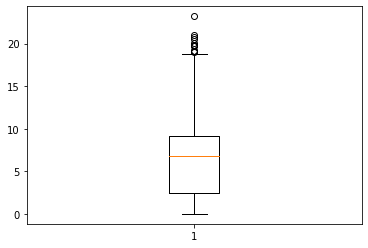

(array([980., 109., 138., 167., 214., 200., 320., 602., 516., 353., 261.,
        173., 129., 104., 102., 105.,  75.,  53.,  48.,  39.,  13.,   6.,
          3.,   0.,   1.]),
 array([ 0.        ,  0.9283269 ,  1.8566538 ,  2.7849807 ,  3.7133076 ,
         4.6416345 ,  5.5699614 ,  6.4982883 ,  7.4266152 ,  8.3549421 ,
         9.28326899, 10.21159589, 11.13992279, 12.06824969, 12.99657659,
        13.92490349, 14.85323039, 15.78155729, 16.70988419, 17.63821109,
        18.56653799, 19.49486489, 20.42319179, 21.35151869, 22.27984559,
        23.20817249]),
 <a list of 25 Patch objects>)

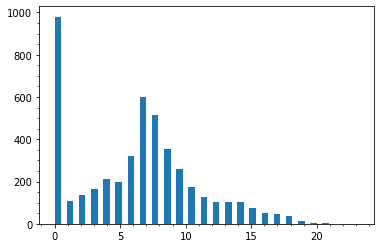

In [4]:
import matplotlib.pyplot as plt

vdf.rename(columns={'attribute.confidentiality.data_total': 'records_lost'}, inplace=True)
vdf
vdf_loss = vdf.dropna(subset=["records_lost"])
vdf_loss['records_lost']
print(v.enum_summary(vdf_loss, 'records_lost'))
# vdf_loss[]
plt.boxplot(np.log(vdf_loss["records_lost"]))
print(vdf_loss.shape)
plt.show()
plt.minorticks_on()
plt.hist(np.log(vdf_loss["records_lost"]), bins = 25, align='mid', width=.5)
    

Total Records Breached, Log Normalized

Employee Counts
               enum     x       n     freq
0       Over 100000   918  3444.0  0.26655
1     1001 to 10000   695  3444.0  0.20180
2       101 to 1000   513  3444.0  0.14895
3         11 to 100   359  3444.0  0.10424
4           1 to 10   267  3444.0  0.07753
5    10001 to 25000   216  3444.0  0.06272
6             Small   185  3444.0  0.05372
7             Large   139  3444.0  0.04036
8    25001 to 50000    99  3444.0  0.02875
9   50001 to 100000    53  3444.0  0.01539
10          Unknown  1267     NaN      NaN


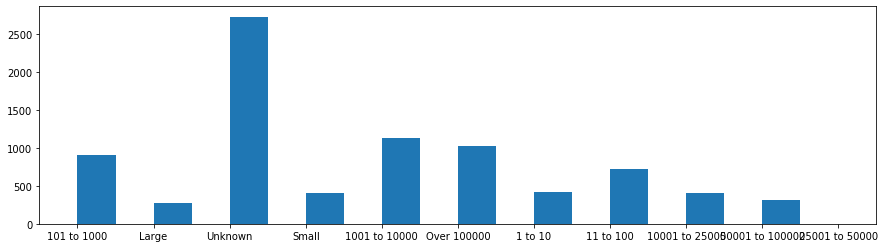

In [5]:

plt.figure(figsize=(15,4))
plt.hist(v.raw_df['victim.employee_count'], align='mid', width = .5) # employee count for the entire distribution

print("Employee Counts")
print(v.enum_summary(vdf_loss, 'victim.employee_count'))
plt.show()
# vdf_loss.assign(employee_count=vdf_loss['victim.employee_count.1 to 10'])

(8363, 173)
(8363, 2476)
(4711, 2476)


(array([358., 453., 513.,   0., 722., 255.,   0., 137.,  88., 918.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

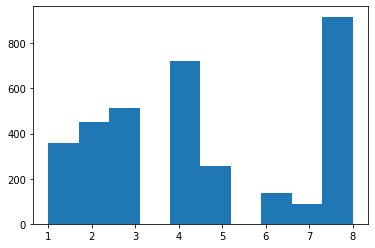

In [6]:
print(v.raw_df.shape)
print(vdf.shape)
print(vdf_loss.shape)
vdf_final = vdf_loss.join(v.raw_df['victim.employee_count']) #Takes from original raw dataframe
vdf_final =  vdf_final[vdf_final['victim.employee_count'] != 'Unknown' ] #Remove unknown employee counts 

emp_counts = v.enumerations['victim.employee_count']
emp_counts

emp_count_map = {'1 to 10' : 1, '11 to 100': 2, '101 to 1000': 3, '1001 to 10000': 4, '10001 to 25000': 5, '25001 to 50000': 6, '50001 to 100000': 7, 'Over 100000': 8}

def order_emp_count(row):
    b = row['victim.employee_count']
    if b == 'Small':
        return np.random.randint(1,3)
    if b == 'Large':
        return np.random.randint(4,8)
    return emp_count_map[b]

vdf_final['emp_ord'] = vdf_final.apply(order_emp_count, axis=1)
vdf_final
plt.hist(vdf_final['emp_ord'])

In [7]:
def assign_bugs(row):
    return row['action.Malware'] | row['action.Hacking']
        
vdf_final['action.Bugs'] = vdf_final.apply(assign_bugs, axis=1)



In [8]:
vdf_final

,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Unknown,action.environmental.notes,action.environmental.variety.Deterioration,...,victim.revenue.iso_currency_code.ZMK,victim.revenue.iso_currency_code.ZWD,victim.secondary.amount,victim.secondary.notes,victim.secondary.victim_id,victim.state,victim.victim_id,victim.employee_count,emp_ord,action.Bugs
1,False,True,False,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,NaN,British Columbia Ministry of Finance,Large,5,False
4,False,False,True,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,NaN,Loyalist Certification Services Exams,1001 to 10000,4,True
7,False,True,False,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,WV,United States Department of Veterans Affairs,Over 100000,8,False
9,False,True,False,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,MO,United States Department of Veterans Affairs,Over 100000,8,False
11,False,False,False,False,False,True,False,False,NaN,False,...,False,False,NaN,NaN,NaN,KS,Occupational Health Partners,11 to 100,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8351,False,False,False,False,False,True,False,False,NaN,False,...,False,False,NaN,NaN,NaN,TX,Pediatric Sports and Spine Associates,11 to 100,2,False
8352,False,True,False,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,CA,google,50001 to 100000,7,False
8353,False,False,False,False,True,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,OH,University Hospitals Elyria Medical Center,1001 to 10000,4,False
8354,False,False,False,False,True,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,NaN,Heartland Regional Health Authority,1001 to 10000,4,False


In [9]:
# df_final['action.Bugs'] = bugs
# df_final


In [10]:
#Creates a smaller table for ease of running
# N = 1000
# sample = np.random.choice(8323, N)
# df_short = df_final.iloc[sample,:].reset_index().iloc[:,1:]


# Maybe we should id the column here in the future so we can refer to the original table values

In [11]:
# impactful_df = vdf[vdf['impact.overall_rating.Insignificant'] | vdf['impact.overall_rating.Distracting'] | vdf['impact.overall_rating.Painful'] | vdf['impact.overall_rating.Catastrophic'] | vdf['impact.overall_rating.Damaging']].reindex()
# reset_impactful_df = impactful_df.reset_index(drop=True) #Resets the indicies
# impactful_df_bugs = reset_impactful_df[reset_impactful_df['action.Hacking'] | reset_impactful_df['action.Malware']]
# impactful_df_bugs


In [12]:
# indices = list(impactful_df_bugs.index)
# bugs = [False] * impactful_df.shape[0]
# for i in indices:
#     bugs[i] = True
# overall_rating = reset_impactful_df.loc[:, reset_impactful_df.columns.str.startswith('impact.overall_rating')]
# df_final = reset_impactful_df.iloc[:, :7]
# df_final['action.Bugs'] = bugs
# result = pd.concat([df_final,overall_rating], axis=1, sort=False)
# result = result.iloc[:,:13]
# result 

In [13]:
#result['outcome'] 

#imp_name = "impact.overall_rating"
#result.apply(outcome: lambda outcome + 1, axis = 1)
#idxs = range(len(result))
#for i in idxs:
#    for rank in ranking.keys():
#        if result.[i][rank]:
#            print(rank) = 
#     for 
#             print result[rank]
# ranking

In [14]:
# impact = [0] * result.shape[0]
# for i in range(result.shape[0]):
#     if(result.loc[i, 'impact.overall_rating.Insignificant']):
#         impact[i] = 1
#     elif(result.loc[i, 'impact.overall_rating.Distracting']):
#         impact[i] = 2
#     elif(result.loc[i, 'impact.overall_rating.Painful']):
#         impact[i] = 3
#     elif(result.loc[i, 'impact.overall_rating.Damaging']):
#         impact[i] = 4
#     elif(result.loc[i, 'impact.overall_rating.Catastrophic']):
#         impact[i] = 5
# result['action.Impact'] = impact #Impact rating column is named 'action.Impact'
# result = result.loc[:, result.columns.str.startswith('action')] #CURRENT FINAL DATAFRAME
# result
# import matplotlib.pyplot as plt
# plt.hist(result["action.Impact"])

In [15]:
import numpy as np
import pandas as pd
import logging
import dowhy
from dowhy.do_why import CausalModel
import graphviz
import dowhy.datasets, dowhy.plotter 

In [16]:
import sys
print(sys.version)

3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [54]:
#Create causal model with instrumental
# print(vdf)
#data
print(vdf_final['records_lost'])

model = CausalModel(
    data = vdf_final,
    treatment = 'action.Bugs',
    outcome = 'records_lost',
    graph = './NetworkXTest/test.gml',
    common_causes = ['emp_ord','action.Environmental', 'action.Error', 'action.Misuse', 'action.Physical', 'action.Social'],
    instruments = ['action.Hacking', 'action.Malware'],
    logging_level = logging.INFO
)
#vdf_final['action.Bugs']
model.view_model(layout="dot")

INFO:dowhy.do_why:Model to find the causal effect of treatment ['action.Bugs'] on outcome ['records_lost']


1             23.0
4            202.0
7              1.0
9              1.0
11          1105.0
           ...    
8351         955.0
8352    52000000.0
8353         297.0
8354         833.0
8356        1025.0
Name: records_lost, Length: 3444, dtype: float64


In [55]:
model.view_model()

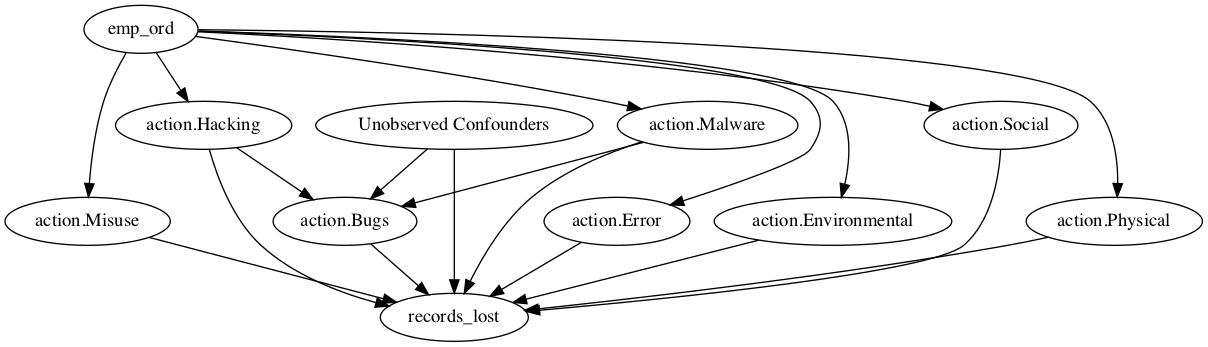

In [56]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [57]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'emp_ord', 'action.Malware', 'action.Hacking']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                       
────────────(Expectation(records_lost|emp_ord,action.Malware,action.Hacking))
daction.Bugs                                                                 
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,emp_ord,action.Malware,action.Hacking,U) = P(records_lost|action.Bugs,emp_ord,action.Malware,action.Hacking)
### Estimand : 2
Estimand name: iv
No such variable found!



INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+emp_ord+action.Malware+action.Hacking


Causal Estimate is 21448096.097986963


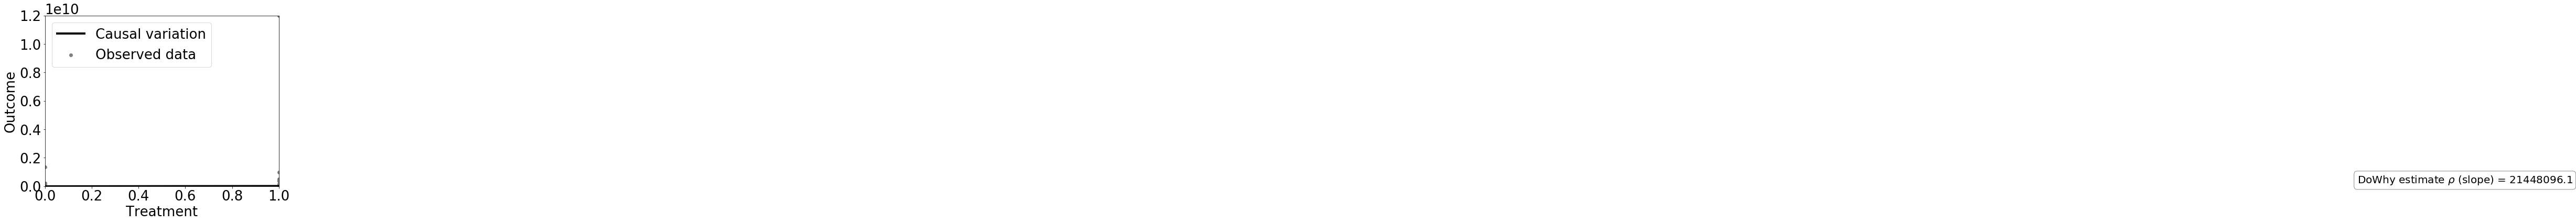

In [21]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, vdf_final['action.Bugs'], vdf_final['records_lost'])
# I think the issue is our data isn't giving us a linear plot... this is linear regression after all

In [22]:
print("DoWhy estimate is " + str(estimate.value))
rvar = 1 if np.random.uniform() >0.5 else 0
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is 21448096.097986963
Actual true causal effect was 1


In [23]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'emp_ord', 'action.Malware', 'action.Hacking']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                       
────────────(Expectation(records_lost|emp_ord,action.Malware,action.Hacking))
daction.Bugs                                                                 
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,emp_ord,action.Malware,action.Hacking,U) = P(records_lost|action.Bugs,emp_ord,action.Malware,action.Hacking)
### Estimand : 2
Estimand name: iv
No such variable found!



## Method 1: Stratification

In [24]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+emp_ord+action.Malware+action.Hacking


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                       
────────────(Expectation(records_lost|emp_ord,action.Malware,action.Hacking))
daction.Bugs                                                                 
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,emp_ord,action.Malware,action.Hacking,U) = P(records_lost|action.Bugs,emp_ord,action.Malware,action.Hacking)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: records_lost~action.Bugs+emp_ord+action.Malware+action.Hacking
## Estimate
Value: nan

Causal Estimate is nan


/Users/ethanpaek/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ethanpaek/opt/anaconda3/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:79: RuntimeWarning: invalid value encountered in double_scalars
  ate = (weighted_outcomes['effect'] * weighted_outcomes[treatment_sum_name]).sum() / total_treatment_population


## Method 2: Matching

In [25]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+emp_ord+action.Malware+action.Hacking
/Users/ethanpaek/opt/anaconda3/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                       
────────────(Expectation(records_lost|emp_ord,action.Malware,action.Hacking))
daction.Bugs                                                                 
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,emp_ord,action.Malware,action.Hacking,U) = P(records_lost|action.Bugs,emp_ord,action.Malware,action.Hacking)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: records_lost~action.Bugs+emp_ord+action.Malware+action.Hacking
## Estimate
Value: 26468823.66568483

Causal Estimate is 26468823.66568483
